In [ ]:
# Parkinson's Disease Classification using MRI Data and Biomarkers
# ================================================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Deep learning imports
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:


# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# 1. Data Loading from Kaggle
# ===========================

# Import kagglehub for dataset download
import kagglehub

# Download the neurodegenerative diseases dataset
print("Downloading Kaggle dataset...")
path = kagglehub.dataset_download("toshall/neurodegenerative-diseases")
print("Dataset downloaded to:", path)

# Define dataset path using the downloaded path
base_path = path

TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


100%|██████████| 60.2M/60.2M [00:00<00:00, 99.5MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1


In [ ]:

# Define expected subdirectories based on dataset description
alzheimer_dir = os.path.join(base_path, "Alzheimer's Disease Dataset")
normal_dir = os.path.join(base_path, "Normal Dataset")
parkinsons_dir = os.path.join(base_path, "Parkinson's Disease Dataset")

# Check if the directories exist
print(f"Alzheimer's directory exists: {os.path.exists(alzheimer_dir)}")
print(f"Normal directory exists: {os.path.exists(normal_dir)}")
print(f"Parkinson's directory exists: {os.path.exists(parkinsons_dir)}")

# List the contents of the base directory to understand structure
print("\nContents of base directory:")
try:
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path):
            print(f"- Directory: {item} (contains {len(os.listdir(item_path))} items)")
        else:
            print(f"- File: {item}")
except Exception as e:
    print(f"Error listing base directory: {e}")

# If the expected structure isn't found, look for an alternative structure
if not all([os.path.exists(alzheimer_dir), os.path.exists(normal_dir), os.path.exists(parkinsons_dir)]):
    print("\nSearching for alternative dataset structure...")
    try:
        # Check subdirectories of the base path to find the dataset
        found_dirs = []
        for root, dirs, files in os.walk(base_path, topdown=True):
            for dir_name in dirs:
                if "alzheimer" in dir_name.lower():
                    alzheimer_dir = os.path.join(root, dir_name)
                    found_dirs.append(("Alzheimer's", alzheimer_dir))
                elif "normal" in dir_name.lower() or "control" in dir_name.lower():
                    normal_dir = os.path.join(root, dir_name)
                    found_dirs.append(("Normal", normal_dir))
                elif "parkinson" in dir_name.lower():
                    parkinsons_dir = os.path.join(root, dir_name)
                    found_dirs.append(("Parkinson's", parkinsons_dir))

        print("\nFound directories:")
        for name, path in found_dirs:
            print(f"- {name}: {path}")
    except Exception as e:
        print(f"Error searching for alternative structure: {e}")

# Function to count images in each directory and its subdirectories
def count_images(directory):
    image_count = 0
    try:
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_count += 1
    except Exception as e:
        print(f"Error counting images in {directory}: {e}")
    return image_count

# Print dataset statistics
print("\nDataset Statistics:")
alzheimer_count = count_images(alzheimer_dir)
normal_count = count_images(normal_dir)
parkinsons_count = count_images(parkinsons_dir)

print(f"Alzheimer's Disease Images: {alzheimer_count}")
print(f"Normal Control Images: {normal_count}")
print(f"Parkinson's Disease Images: {parkinsons_count}")

Alzheimer's directory exists: False
Normal directory exists: False
Parkinson's directory exists: False

Contents of base directory:
- Directory: alzheimers_dataset (contains 2500 items)
- Directory: parkinsons_dataset (contains 2391 items)
- Directory: normal (contains 2699 items)

Searching for alternative dataset structure...

Found directories:
- Alzheimer's: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/alzheimers_dataset
- Parkinson's: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/parkinsons_dataset
- Normal: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/normal

Dataset Statistics:
Alzheimer's Disease Images: 2500
Normal Control Images: 2699
Parkinson's Disease Images: 2391


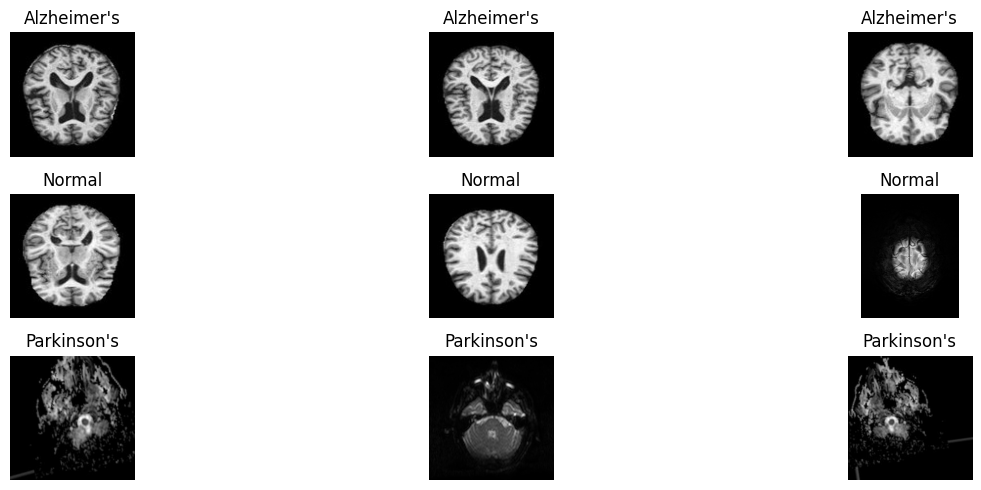

In [ ]:


# Function to display random sample images from each class
def display_samples(directories, class_names, samples_per_class=3, figsize=(15, 5)):
    plt.figure(figsize=figsize)

    for i, (directory, class_name) in enumerate(zip(directories, class_names)):
        all_images = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(root, file))

        # Select random samples
        if len(all_images) >= samples_per_class:
            samples = random.sample(all_images, samples_per_class)

            for j, img_path in enumerate(samples):
                img = Image.open(img_path)
                plt.subplot(len(directories), samples_per_class, i*samples_per_class + j + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{class_name}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
display_samples(
    [alzheimer_dir, normal_dir, parkinsons_dir],
    ["Alzheimer's", "Normal", "Parkinson's"]
)


In [ ]:

# 2. Data Preprocessing
# =====================

# Define image dimensions and batch size
img_height, img_width = 224, 224  # Standard size for many pre-trained models
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data


In [ ]:

# Function to prepare datasets from the directories
def prepare_binary_dataset():
    """
    Prepare binary classification dataset: Parkinson's vs. Normal
    """
    # Use direct data flow from directories - expect train/val/test splits in the dataset

    print("Loading binary classification dataset (Parkinson's vs. Normal)...")

    # Create training generators for Parkinson's vs. Normal
    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'train_binary'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['normal', 'parkinsons'],
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'train_binary'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['normal', 'parkinsons'],
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'test_binary'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        classes=['normal', 'parkinsons']
    )

    return train_generator, validation_generator, test_generator


In [ ]:

def prepare_multiclass_dataset():
    """
    Prepare multi-class classification dataset: Parkinson's vs. Normal vs. Alzheimer's
    """
    print("Loading multi-class classification dataset...")

    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'train_multiclass'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['normal', 'parkinsons', 'alzheimers'],
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'train_multiclass'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['normal', 'parkinsons', 'alzheimers'],
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        directory=os.path.join(base_path, 'test_multiclass'),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        classes=['normal', 'parkinsons', 'alzheimers']
    )

    return train_generator, validation_generator, test_generator

# Check the dataset organization
print("\nChecking dataset organization...")
for root, dirs, files in os.walk(base_path, topdown=True):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Number of files: {len(files)}")
    print("---")



Checking dataset organization...
Directory: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1
Subdirectories: ['alzheimers_dataset', 'parkinsons_dataset', 'normal']
Number of files: 0
---
Directory: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/alzheimers_dataset
Subdirectories: []
Number of files: 2500
---
Directory: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/parkinsons_dataset
Subdirectories: []
Number of files: 2391
---
Directory: /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/normal
Subdirectories: []
Number of files: 2699
---


In [ ]:

# If the dataset doesn't have the expected structure, create it
def organize_dataset():
    """
    Organize the dataset into the expected structure if it's not already organized
    """
    print("Organizing dataset...")

    # Paths for binary classification (Parkinson's vs. Normal)
    train_binary = os.path.join(base_path, 'train_binary')
    test_binary = os.path.join(base_path, 'test_binary')

    os.makedirs(os.path.join(train_binary, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(train_binary, 'parkinsons'), exist_ok=True)
    os.makedirs(os.path.join(test_binary, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(test_binary, 'parkinsons'), exist_ok=True)

    # Paths for multi-class classification
    train_multiclass = os.path.join(base_path, 'train_multiclass')
    test_multiclass = os.path.join(base_path, 'test_multiclass')

    os.makedirs(os.path.join(train_multiclass, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(train_multiclass, 'parkinsons'), exist_ok=True)
    os.makedirs(os.path.join(train_multiclass, 'alzheimers'), exist_ok=True)
    os.makedirs(os.path.join(test_multiclass, 'normal'), exist_ok=True)
    os.makedirs(os.path.join(test_multiclass, 'parkinsons'), exist_ok=True)
    os.makedirs(os.path.join(test_multiclass, 'alzheimers'), exist_ok=True)

    # Function to organize a single class
    def organize_class(src_dir, train_dir, test_dir, test_split=0.2):
        files = []
        for root, _, filenames in os.walk(src_dir):
            for filename in filenames:
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    files.append(os.path.join(root, filename))

        # Shuffle and split
        random.shuffle(files)
        split_idx = int(len(files) * (1 - test_split))
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        # Copy files
        for i, file in enumerate(tqdm(train_files, desc=f"Copying train files to {train_dir}")):
            img = Image.open(file)
            img.save(os.path.join(train_dir, f"{i:05d}.jpg"))

        for i, file in enumerate(tqdm(test_files, desc=f"Copying test files to {test_dir}")):
            img = Image.open(file)
            img.save(os.path.join(test_dir, f"{i:05d}.jpg"))

        return len(train_files), len(test_files)

    # Organize each class
    normal_train, normal_test = organize_class(
        normal_dir,
        os.path.join(train_binary, 'normal'),
        os.path.join(test_binary, 'normal')
    )

    parkinsons_train, parkinsons_test = organize_class(
        parkinsons_dir,
        os.path.join(train_binary, 'parkinsons'),
        os.path.join(test_binary, 'parkinsons')
    )

    alzheimers_train, alzheimers_test = organize_class(
        alzheimer_dir,
        os.path.join(train_multiclass, 'alzheimers'),
        os.path.join(test_multiclass, 'alzheimers')
    )

    # Copy binary classes to multiclass directories
    organize_class(
        os.path.join(train_binary, 'normal'),
        os.path.join(train_multiclass, 'normal'),
        os.path.join(test_multiclass, 'normal'),
        test_split=0.0  # Already split
    )

    organize_class(
        os.path.join(train_binary, 'parkinsons'),
        os.path.join(train_multiclass, 'parkinsons'),
        os.path.join(test_multiclass, 'parkinsons'),
        test_split=0.0  # Already split
    )

    print(f"Dataset organized. Binary classification:")
    print(f"Normal: {normal_train} train, {normal_test} test")
    print(f"Parkinson's: {parkinsons_train} train, {parkinsons_test} test")
    print(f"Multi-class includes Alzheimer's: {alzheimers_train} train, {alzheimers_test} test")

# Organize the dataset if needed
organize_dataset()


Organizing dataset...


Copying train files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/train_binary/normal: 100%|██████████| 2159/2159 [00:02<00:00, 933.57it/s]
Copying test files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/test_binary/normal: 100%|██████████| 540/540 [00:00<00:00, 1023.72it/s]
Copying train files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/train_binary/parkinsons: 100%|██████████| 1912/1912 [00:02<00:00, 698.64it/s]
Copying test files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/test_binary/parkinsons: 100%|██████████| 479/479 [00:00<00:00, 792.94it/s]
Copying train files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/train_multiclass/alzheimers: 100%|██████████| 2000/2000 [00:01<00:00, 1479.84it/s]
Copying test files to /root/.cache/kagglehub/datasets/toshall/neurodegenerative-diseases/versions/1/test_multiclass

Dataset organized. Binary classification:
Normal: 2159 train, 540 test
Parkinson's: 1912 train, 479 test
Multi-class includes Alzheimer's: 2000 train, 500 test


In [ ]:

# 3. Model Development
# ====================

# 3.1 Build a CNN for Binary Classification (Objective 1)
def build_cnn_model():
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification (0: Normal, 1: Parkinson's)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]
    )

    return model


In [ ]:

# 3.2 Build a Transfer Learning Model using VGG16 (Objective 2)
def build_transfer_learning_model(num_classes=3):  # Default for multi-class
    # Load the VGG16 model pre-trained on ImageNet
    base_model = applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    # Freeze the base model layers
    base_model.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        # Output layer depends on classification type
        layers.Dense(num_classes if num_classes > 2 else 1,
                    activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    # Compile the model with appropriate loss function
    if num_classes <= 2:  # Binary classification
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()]
        )
    else:  # Multi-class classification
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()]
        )

    return model


In [ ]:

# 4. Model Training and Evaluation
# ===============================

# 4.1 Binary Classification Model (Parkinson's vs. Normal)
def train_binary_model():
    print("\nTraining Binary Classification Model (Parkinson's vs. Normal)...")

    # Prepare data
    train_generator, validation_generator, test_generator = prepare_binary_dataset()

    # Build the model
    model = build_cnn_model()

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('parkinsons_binary_model.h5', save_best_only=True)
    ]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks
    )

    # Evaluate the model
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Generate predictions for confusion matrix
    y_pred = []
    y_true = []

    # Reset the generator
    test_generator.reset()

    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        y_pred_batch = model.predict(x_batch)
        y_pred.extend((y_pred_batch > 0.5).astype(int).flatten())
        y_true.extend(y_batch.astype(int))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Parkinson\'s'],
               yticklabels=['Normal', 'Parkinson\'s'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Parkinson\'s']))

    return model, history


In [ ]:

# 4.2 Multi-class Classification Model (Parkinson's vs. Normal vs. Alzheimer's)
def train_multiclass_model():
    print("\nTraining Multi-class Classification Model (Parkinson's vs. Normal vs. Alzheimer's)...")

    # Prepare data
    train_generator, validation_generator, test_generator = prepare_multiclass_dataset()

    # Build the model using transfer learning
    model = build_transfer_learning_model(num_classes=3)

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
        ModelCheckpoint('parkinsons_multiclass_model.h5', save_best_only=True)
    ]

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks
    )

    # Evaluate the model
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Generate predictions for confusion matrix
    test_generator.reset()
    y_pred = model.predict(test_generator, steps=len(test_generator))
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    test_generator.reset()
    y_true = []
    for i in range(len(test_generator)):
        _, y_batch = test_generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Normal', 'Parkinson\'s', 'Alzheimer\'s'],
               yticklabels=['Normal', 'Parkinson\'s', 'Alzheimer\'s'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes,
                              target_names=['Normal', 'Parkinson\'s', 'Alzheimer\'s']))

    return model, history


In [ ]:

# 5. Biomarker Identification (Objective 3)
# =========================================

def identify_biomarkers(model, test_generator):
    """
    Use Grad-CAM to visualize important regions in MRI images that contribute to model predictions
    """
    print("\nIdentifying Biomarkers using Grad-CAM...")

    # Get a batch of test images
    test_generator.reset()
    x_batch, y_batch = next(test_generator)

    # Create a Grad-CAM visualization model
    # This code assumes a CNN model with convolutional layers

    # For a basic CNN model
    if isinstance(model.layers[0], tf.keras.layers.Conv2D):
        # Find the last convolutional layer
        last_conv_layer = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer = layer
                break

        if last_conv_layer is None:
            print("No convolutional layer found in the model.")
            return

        # Create a model that outputs both the last conv layer and the final output
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(last_conv_layer.name).output, model.output]
        )

    # For a transfer learning model (VGG16)
    else:
        # Assuming VGG16 is the base model
        last_conv_layer_name = "block5_conv3"  # Last conv layer in VGG16

        # Get the VGG16 model
        vgg_model = model.layers[0]

        # Create a model that outputs both the last conv layer and the final output
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[vgg_model.get_layer(last_conv_layer_name).output, model.output]
        )

    # Visualize Grad-CAM for a few sample images
    plt.figure(figsize=(15, 10))

    for i in range(min(5, x_batch.shape[0])):
        # Expand dimensions to create a batch of one
        img = np.expand_dims(x_batch[i], axis=0)

        # Get the predicted class
        pred = model.predict(img)
        if pred.shape[1] == 1:  # Binary classification
            pred_class = 1 if pred[0][0] > 0.5 else 0
            class_names = ['Normal', 'Parkinson\'s']
        else:  # Multi-class
            pred_class = np.argmax(pred[0])
            class_names = ['Normal', 'Parkinson\'s', 'Alzheimer\'s']

        # Calculate gradients
        with tf.GradientTape() as tape:
            conv_output, predictions = grad_model(img)
            if predictions.shape[1] == 1:  # Binary classification
                loss = predictions[:, 0]
            else:  # Multi-class
                loss = predictions[:, pred_class]

        # Get the gradients of the loss with respect to the outputs of the last conv layer
        grads = tape.gradient(loss, conv_output)

        # Get the pooled gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Multiply each channel in the feature map by the importance
        conv_output = conv_output[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

        # Normalize the heatmap
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()

        # Resize the heatmap to the size of the input image
        heatmap = np.uint8(255 * heatmap)
        heatmap = Image.fromarray(heatmap)
        heatmap = heatmap.resize((img_width, img_height))
        heatmap = np.array(heatmap)

        # Display the original image
        plt.subplot(5, 3, i*3 + 1)
        plt.imshow(x_batch[i])
        plt.title(f"Original - Pred: {class_names[pred_class]}")
        plt.axis('off')

        # Display the heatmap
        plt.subplot(5, 3, i*3 + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title("Heatmap")
        plt.axis('off')

        # Superimpose the heatmap on the original image
        img_array = (x_batch[i] * 255).astype(np.uint8)
        colored_heatmap = np.uint8(plt.cm.jet(heatmap / 255)[..., :3] * 255)
        superimposed = colored_heatmap * 0.4 + img_array * 0.6
        superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)

        plt.subplot(5, 3, i*3 + 3)
        plt.imshow(superimposed)
        plt.title("Superimposed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print("\nPotential Biomarkers:")
    print("- The highlighted regions in the heatmaps indicate areas that strongly influence the model's predictions.")
    print("- These regions may contain biomarkers specific to Parkinson's disease.")
    print("- In particular, look for consistent patterns across multiple Parkinson's positive cases.")
    print("- Areas with high activation in the basal ganglia, substantia nigra, and striatum may be particularly relevant for Parkinson's disease detection.")



Training Binary Classification Model (Parkinson's vs. Normal)...
Loading binary classification dataset (Parkinson's vs. Normal)...
Found 3258 images belonging to 2 classes.
Found 813 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8982 - auc: 0.9541 - loss: 0.2966 - precision: 0.8918 - recall: 0.8952

102/102 ━━━━━━━━━━━━━━━━━━━━ 83s 660ms/step - accuracy: 0.8985 - auc: 0.9543 - loss: 0.2958 - precision: 0.8921 - recall: 0.8954 - val_accuracy: 0.5301 - val_auc: 0.5262 - val_loss: 2.3751 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9598 - auc: 0.9882 - loss: 0.1256 - precision: 0.9561 - recall: 0.9542

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 480ms/step - accuracy: 0.9598 - auc: 0.9882 - loss: 0.1256 - precision: 0.9562 - recall: 0.9542 - val_accuracy: 0.5301 - val_auc: 0.3149 - val_loss: 1.2080 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 479ms/step - accuracy: 0.9668 - auc: 0.9927 - loss: 0.0946 - precision: 0.9712 - recall: 0.9595 - val_accuracy: 0.4895 - val_auc: 0.4745 - val_loss: 1.6890 - val_precision: 0.4787 - val_recall: 0.9686 - learning_rate: 1.0000e-04
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 473ms/step - accuracy: 0.9685 - auc: 0.9939 - loss: 0.0914 - precision: 0.9758 - recall: 0.9568 - val_accuracy: 0.4969 - val_auc: 0.4364 - val_loss: 2.2701 - val_precision: 0.4781 - val_recall: 0.7723 - learning_rate: 1.0000e-04
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 475ms/step - accuracy: 0.9765 - auc: 0.9959 - loss: 0.0686 - precision: 0.9755 - recall: 0.9741 - val_accuracy: 0.5068 - val_auc: 0.6693 - v

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 481ms/step - accuracy: 0.9837 - auc: 0.9967 - loss: 0.0506 - precision: 0.9860 - recall: 0.9797 - val_accuracy: 0.9779 - val_auc: 0.9992 - val_loss: 0.0444 - val_precision: 0.9946 - val_recall: 0.9581 - learning_rate: 1.0000e-04
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 469ms/step - accuracy: 0.9858 - auc: 0.9992 - loss: 0.0371 - precision: 0.9845 - recall: 0.9847 - val_accuracy: 0.8954 - val_auc: 0.9932 - val_loss: 0.2811 - val_precision: 1.0000 - val_recall: 0.7775 - learning_rate: 1.0000e-04
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9872 - auc: 0.9983 - loss: 0.0392 - precision: 0.9895 - recall: 0.9835

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 478ms/step - accuracy: 0.9872 - auc: 0.9983 - loss: 0.0392 - precision: 0.9894 - recall: 0.9835 - val_accuracy: 0.9926 - val_auc: 0.9998 - val_loss: 0.0224 - val_precision: 1.0000 - val_recall: 0.9843 - learning_rate: 1.0000e-04
Epoch 10/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 469ms/step - accuracy: 0.9796 - auc: 0.9980 - loss: 0.0542 - precision: 0.9843 - recall: 0.9720 - val_accuracy: 0.9065 - val_auc: 0.9804 - val_loss: 0.3372 - val_precision: 1.0000 - val_recall: 0.8010 - learning_rate: 1.0000e-04
Epoch 11/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 472ms/step - accuracy: 0.9877 - auc: 0.9986 - loss: 0.0339 - precision: 0.9939 - recall: 0.9799 - val_accuracy: 0.9606 - val_auc: 0.9992 - val_loss: 0.1058 - val_precision: 0.9248 - val_recall: 0.9974 - learning_rate: 1.0000e-04
Epoch 12/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 475ms/step - accuracy: 0.9853 - auc: 0.9990 - loss: 0.0350 - precision: 0.9839 - recall: 0.9840 - val_accuracy: 0.9852 - val_auc: 0.9979 - val_lo

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 479ms/step - accuracy: 0.9933 - auc: 0.9998 - loss: 0.0189 - precision: 0.9934 - recall: 0.9922 - val_accuracy: 0.9902 - val_auc: 0.9999 - val_loss: 0.0141 - val_precision: 0.9973 - val_recall: 0.9817 - learning_rate: 2.0000e-05
Epoch 16/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9934 - auc: 0.9997 - loss: 0.0215 - precision: 0.9925 - recall: 0.9934

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 478ms/step - accuracy: 0.9934 - auc: 0.9997 - loss: 0.0215 - precision: 0.9925 - recall: 0.9934 - val_accuracy: 0.9963 - val_auc: 0.9999 - val_loss: 0.0136 - val_precision: 1.0000 - val_recall: 0.9921 - learning_rate: 2.0000e-05
Epoch 17/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9928 - auc: 0.9999 - loss: 0.0170 - precision: 0.9940 - recall: 0.9908

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 481ms/step - accuracy: 0.9928 - auc: 0.9999 - loss: 0.0170 - precision: 0.9940 - recall: 0.9908 - val_accuracy: 0.9938 - val_auc: 1.0000 - val_loss: 0.0124 - val_precision: 1.0000 - val_recall: 0.9869 - learning_rate: 2.0000e-05
Epoch 18/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 81s 472ms/step - accuracy: 0.9960 - auc: 0.9999 - loss: 0.0137 - precision: 0.9970 - recall: 0.9945 - val_accuracy: 0.9975 - val_auc: 0.9999 - val_loss: 0.0127 - val_precision: 0.9974 - val_recall: 0.9974 - learning_rate: 2.0000e-05
Epoch 19/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 472ms/step - accuracy: 0.9934 - auc: 0.9999 - loss: 0.0169 - precision: 0.9955 - recall: 0.9910 - val_accuracy: 0.9926 - val_auc: 0.9999 - val_loss: 0.0239 - val_precision: 0.9845 - val_recall: 1.0000 - learning_rate: 2.0000e-05
Epoch 20/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.9941 - auc: 0.9997 - loss: 0.0154 - precision: 0.9962 - recall: 0.9911

102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 478ms/step - accuracy: 0.9941 - auc: 0.9997 - loss: 0.0155 - precision: 0.9962 - recall: 0.9911 - val_accuracy: 0.9963 - val_auc: 1.0000 - val_loss: 0.0080 - val_precision: 1.0000 - val_recall: 0.9921 - learning_rate: 2.0000e-05
Epoch 21/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 474ms/step - accuracy: 0.9969 - auc: 0.9997 - loss: 0.0157 - precision: 0.9961 - recall: 0.9973 - val_accuracy: 0.9963 - val_auc: 1.0000 - val_loss: 0.0113 - val_precision: 0.9974 - val_recall: 0.9948 - learning_rate: 2.0000e-05
Epoch 22/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 484ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0120 - precision: 0.9954 - recall: 0.9964 - val_accuracy: 0.9951 - val_auc: 0.9999 - val_loss: 0.0162 - val_precision: 0.9922 - val_recall: 0.9974 - learning_rate: 2.0000e-05
Epoch 23/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 470ms/step - accuracy: 0.9948 - auc: 0.9997 - loss: 0.0148 - precision: 0.9955 - recall: 0.9936 - val_accuracy: 0.9975 - val_auc: 0.9999 - val_lo

102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 469ms/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0080 - precision: 0.9969 - recall: 0.9989 - val_accuracy: 0.9975 - val_auc: 1.0000 - val_loss: 0.0056 - val_precision: 1.0000 - val_recall: 0.9948 - learning_rate: 4.0000e-06
Epoch 27/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 480ms/step - accuracy: 0.9980 - auc: 0.9994 - loss: 0.0110 - precision: 0.9986 - recall: 0.9971 - val_accuracy: 0.9975 - val_auc: 1.0000 - val_loss: 0.0068 - val_precision: 0.9948 - val_recall: 1.0000 - learning_rate: 4.0000e-06
Epoch 28/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 480ms/step - accuracy: 0.9975 - auc: 0.9999 - loss: 0.0095 - precision: 0.9966 - recall: 0.9981 - val_accuracy: 0.9926 - val_auc: 1.0000 - val_loss: 0.0125 - val_precision: 1.0000 - val_recall: 0.9843 - learning_rate: 4.0000e-06
Epoch 29/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 48s 471ms/step - accuracy: 0.9944 - auc: 0.9995 - loss: 0.0164 - precision: 0.9951 - recall: 0.9929 - val_accuracy: 0.9963 - val_auc: 1.0000 - val_lo

102/102 ━━━━━━━━━━━━━━━━━━━━ 53s 523ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0074 - precision: 0.9979 - recall: 0.9982 - val_accuracy: 0.9975 - val_auc: 1.0000 - val_loss: 0.0046 - val_precision: 1.0000 - val_recall: 0.9948 - learning_rate: 1.0000e-06
Epoch 35/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 488ms/step - accuracy: 0.9960 - auc: 0.9999 - loss: 0.0116 - precision: 0.9960 - recall: 0.9955 - val_accuracy: 0.9951 - val_auc: 1.0000 - val_loss: 0.0110 - val_precision: 1.0000 - val_recall: 0.9895 - learning_rate: 1.0000e-06
Epoch 36/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 50s 490ms/step - accuracy: 0.9950 - auc: 0.9999 - loss: 0.0127 - precision: 0.9977 - recall: 0.9922 - val_accuracy: 0.9963 - val_auc: 1.0000 - val_loss: 0.0064 - val_precision: 1.0000 - val_recall: 0.9921 - learning_rate: 1.0000e-06
Epoch 37/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 51s 496ms/step - accuracy: 0.9927 - auc: 0.9998 - loss: 0.0156 - precision: 0.9905 - recall: 0.9938 - val_accuracy: 0.9938 - val_auc: 1.0000 - val_lo

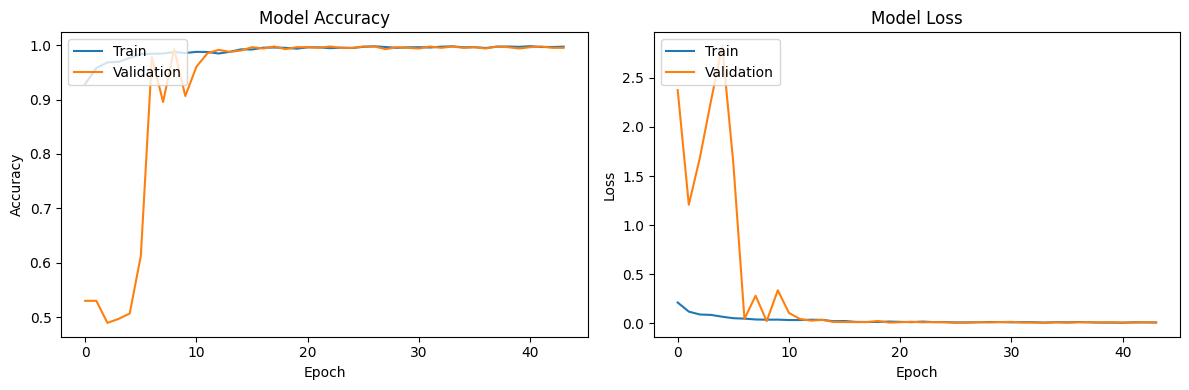

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

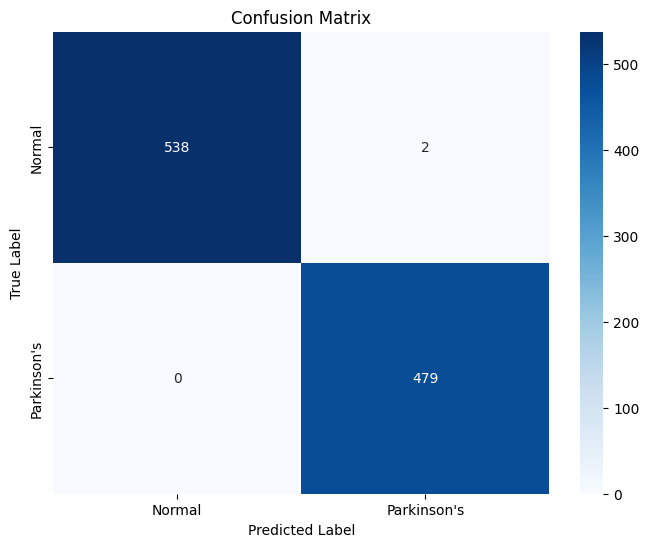


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       540
 Parkinson's       1.00      1.00      1.00       479

    accuracy                           1.00      1019
   macro avg       1.00      1.00      1.00      1019
weighted avg       1.00      1.00      1.00      1019



In [ ]:
# 6. Main Execution
# ================

# Train binary classification model
binary_model, binary_history = train_binary_model()




Training Multi-class Classification Model (Parkinson's vs. Normal vs. Alzheimer's)...
Loading multi-class classification dataset...
Found 4858 images belonging to 3 classes.
Found 1213 images belonging to 3 classes.
Found 500 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5772 - auc_1: 0.7783 - loss: 1.1495 - precision_1: 0.5895 - recall_1: 0.5591

152/152 ━━━━━━━━━━━━━━━━━━━━ 122s 681ms/step - accuracy: 0.5777 - auc_1: 0.7787 - loss: 1.1482 - precision_1: 0.5899 - recall_1: 0.5596 - val_accuracy: 0.6472 - val_auc_1: 0.8395 - val_loss: 0.7847 - val_precision_1: 0.6305 - val_recall_1: 0.5837 - learning_rate: 1.0000e-04
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7114 - auc_1: 0.8911 - loss: 0.7362 - precision_1: 0.7198 - recall_1: 0.7048

152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 522ms/step - accuracy: 0.7114 - auc_1: 0.8911 - loss: 0.7360 - precision_1: 0.7199 - recall_1: 0.7049 - val_accuracy: 0.6991 - val_auc_1: 0.9118 - val_loss: 0.5465 - val_precision_1: 0.7163 - val_recall_1: 0.6620 - learning_rate: 1.0000e-04
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7426 - auc_1: 0.9123 - loss: 0.6308 - precision_1: 0.7462 - recall_1: 0.7361

152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 521ms/step - accuracy: 0.7426 - auc_1: 0.9123 - loss: 0.6308 - precision_1: 0.7461 - recall_1: 0.7361 - val_accuracy: 0.7222 - val_auc_1: 0.9258 - val_loss: 0.4608 - val_precision_1: 0.7286 - val_recall_1: 0.7082 - learning_rate: 1.0000e-04
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7261 - auc_1: 0.9117 - loss: 0.6178 - precision_1: 0.7320 - recall_1: 0.7200

152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 522ms/step - accuracy: 0.7262 - auc_1: 0.9117 - loss: 0.6177 - precision_1: 0.7321 - recall_1: 0.7201 - val_accuracy: 0.7914 - val_auc_1: 0.9455 - val_loss: 0.4038 - val_precision_1: 0.7938 - val_recall_1: 0.7840 - learning_rate: 1.0000e-04
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7477 - auc_1: 0.9156 - loss: 0.6052 - precision_1: 0.7513 - recall_1: 0.7420

152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 516ms/step - accuracy: 0.7477 - auc_1: 0.9157 - loss: 0.6051 - precision_1: 0.7513 - recall_1: 0.7421 - val_accuracy: 0.8211 - val_auc_1: 0.9530 - val_loss: 0.3809 - val_precision_1: 0.8220 - val_recall_1: 0.8186 - learning_rate: 1.0000e-04
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7676 - auc_1: 0.9234 - loss: 0.5690 - precision_1: 0.7713 - recall_1: 0.7626

152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 518ms/step - accuracy: 0.7676 - auc_1: 0.9234 - loss: 0.5689 - precision_1: 0.7713 - recall_1: 0.7626 - val_accuracy: 0.8162 - val_auc_1: 0.9540 - val_loss: 0.3743 - val_precision_1: 0.8162 - val_recall_1: 0.8129 - learning_rate: 1.0000e-04
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 512ms/step - accuracy: 0.7654 - auc_1: 0.9288 - loss: 0.5279 - precision_1: 0.7670 - recall_1: 0.7605 - val_accuracy: 0.8129 - val_auc_1: 0.9544 - val_loss: 0.3785 - val_precision_1: 0.8155 - val_recall_1: 0.8087 - learning_rate: 1.0000e-04
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7601 - auc_1: 0.9267 - loss: 0.5328 - precision_1: 0.7618 - recall_1: 0.7553

152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 554ms/step - accuracy: 0.7602 - auc_1: 0.9267 - loss: 0.5327 - precision_1: 0.7619 - recall_1: 0.7553 - val_accuracy: 0.8186 - val_auc_1: 0.9556 - val_loss: 0.3635 - val_precision_1: 0.8213 - val_recall_1: 0.8145 - learning_rate: 1.0000e-04
Epoch 9/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7723 - auc_1: 0.9312 - loss: 0.5052 - precision_1: 0.7758 - recall_1: 0.7677

152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 548ms/step - accuracy: 0.7723 - auc_1: 0.9312 - loss: 0.5052 - precision_1: 0.7758 - recall_1: 0.7677 - val_accuracy: 0.8228 - val_auc_1: 0.9581 - val_loss: 0.3553 - val_precision_1: 0.8234 - val_recall_1: 0.8228 - learning_rate: 1.0000e-04
Epoch 10/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7868 - auc_1: 0.9394 - loss: 0.4786 - precision_1: 0.7885 - recall_1: 0.7833

152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 550ms/step - accuracy: 0.7868 - auc_1: 0.9394 - loss: 0.4786 - precision_1: 0.7885 - recall_1: 0.7833 - val_accuracy: 0.8178 - val_auc_1: 0.9613 - val_loss: 0.3414 - val_precision_1: 0.8178 - val_recall_1: 0.8178 - learning_rate: 1.0000e-04
Epoch 11/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 547ms/step - accuracy: 0.7748 - auc_1: 0.9337 - loss: 0.4925 - precision_1: 0.7774 - recall_1: 0.7725 - val_accuracy: 0.8071 - val_auc_1: 0.9569 - val_loss: 0.3586 - val_precision_1: 0.8084 - val_recall_1: 0.8071 - learning_rate: 1.0000e-04
Epoch 12/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 520ms/step - accuracy: 0.7721 - auc_1: 0.9369 - loss: 0.4795 - precision_1: 0.7753 - recall_1: 0.7692 - val_accuracy: 0.8087 - val_auc_1: 0.9551 - val_loss: 0.3653 - val_precision_1: 0.8099 - val_recall_1: 0.8079 - learning_rate: 1.0000e-04
Epoch 13/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - accuracy: 0.7879 - auc_1: 0.9395 - loss: 0.4693 - precision_1: 0.7894 - recall_1: 0.7849 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 527ms/step - accuracy: 0.7856 - auc_1: 0.9409 - loss: 0.4491 - precision_1: 0.7871 - recall_1: 0.7805 - val_accuracy: 0.8302 - val_auc_1: 0.9638 - val_loss: 0.3311 - val_precision_1: 0.8314 - val_recall_1: 0.8293 - learning_rate: 1.0000e-04
Epoch 15/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 509ms/step - accuracy: 0.7820 - auc_1: 0.9405 - loss: 0.4477 - precision_1: 0.7817 - recall_1: 0.7771 - val_accuracy: 0.8005 - val_auc_1: 0.9543 - val_loss: 0.3615 - val_precision_1: 0.8012 - val_recall_1: 0.7972 - learning_rate: 1.0000e-04
Epoch 16/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 515ms/step - accuracy: 0.7905 - auc_1: 0.9448 - loss: 0.4364 - precision_1: 0.7935 - recall_1: 0.7874 - val_accuracy: 0.8211 - val_auc_1: 0.9626 - val_loss: 0.3322 - val_precision_1: 0.8216 - val_recall_1: 0.8203 - learning_rate: 1.0000e-04
Epoch 17/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 511ms/step - accuracy: 0.8005 - auc_1: 0.9480 - loss: 0.4144 - precision_1: 0.8024 - recall_1: 0.7959 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 510ms/step - accuracy: 0.7858 - auc_1: 0.9421 - loss: 0.4446 - precision_1: 0.7876 - recall_1: 0.7815 - val_accuracy: 0.8442 - val_auc_1: 0.9655 - val_loss: 0.3234 - val_precision_1: 0.8442 - val_recall_1: 0.8442 - learning_rate: 1.0000e-04
Epoch 19/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 509ms/step - accuracy: 0.7860 - auc_1: 0.9432 - loss: 0.4298 - precision_1: 0.7874 - recall_1: 0.7822 - val_accuracy: 0.8450 - val_auc_1: 0.9648 - val_loss: 0.3296 - val_precision_1: 0.8455 - val_recall_1: 0.8434 - learning_rate: 1.0000e-04
Epoch 20/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - accuracy: 0.7948 - auc_1: 0.9474 - loss: 0.4206 - precision_1: 0.7968 - recall_1: 0.7922 - val_accuracy: 0.8351 - val_auc_1: 0.9625 - val_loss: 0.3384 - val_precision_1: 0.8346 - val_recall_1: 0.8318 - learning_rate: 1.0000e-04
Epoch 21/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 511ms/step - accuracy: 0.7982 - auc_1: 0.9472 - loss: 0.4171 - precision_1: 0.7998 - recall_1: 0.7959 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 507ms/step - accuracy: 0.7963 - auc_1: 0.9484 - loss: 0.4044 - precision_1: 0.7979 - recall_1: 0.7939 - val_accuracy: 0.8326 - val_auc_1: 0.9670 - val_loss: 0.3162 - val_precision_1: 0.8333 - val_recall_1: 0.8326 - learning_rate: 2.0000e-05
Epoch 27/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 505ms/step - accuracy: 0.8026 - auc_1: 0.9508 - loss: 0.3953 - precision_1: 0.8035 - recall_1: 0.8014 - val_accuracy: 0.8417 - val_auc_1: 0.9673 - val_loss: 0.3176 - val_precision_1: 0.8416 - val_recall_1: 0.8409 - learning_rate: 2.0000e-05
Epoch 28/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 550ms/step - accuracy: 0.8003 - auc_1: 0.9502 - loss: 0.3988 - precision_1: 0.8025 - recall_1: 0.7964 - val_accuracy: 0.8351 - val_auc_1: 0.9644 - val_loss: 0.3260 - val_precision_1: 0.8357 - val_recall_1: 0.8343 - learning_rate: 2.0000e-05
Epoch 29/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 506ms/step - accuracy: 0.8110 - auc_1: 0.9560 - loss: 0.3733 - precision_1: 0.8130 - recall_1: 0.8077 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 508ms/step - accuracy: 0.8020 - auc_1: 0.9485 - loss: 0.4068 - precision_1: 0.8035 - recall_1: 0.8007 - val_accuracy: 0.8450 - val_auc_1: 0.9675 - val_loss: 0.3141 - val_precision_1: 0.8457 - val_recall_1: 0.8450 - learning_rate: 2.0000e-05
Epoch 32/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8185 - auc_1: 0.9552 - loss: 0.3811 - precision_1: 0.8205 - recall_1: 0.8177

152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 519ms/step - accuracy: 0.8185 - auc_1: 0.9552 - loss: 0.3812 - precision_1: 0.8204 - recall_1: 0.8177 - val_accuracy: 0.8475 - val_auc_1: 0.9682 - val_loss: 0.3121 - val_precision_1: 0.8474 - val_recall_1: 0.8467 - learning_rate: 2.0000e-05
Epoch 33/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8113 - auc_1: 0.9519 - loss: 0.3894 - precision_1: 0.8118 - recall_1: 0.8084

152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 546ms/step - accuracy: 0.8113 - auc_1: 0.9520 - loss: 0.3893 - precision_1: 0.8118 - recall_1: 0.8084 - val_accuracy: 0.8533 - val_auc_1: 0.9707 - val_loss: 0.3029 - val_precision_1: 0.8540 - val_recall_1: 0.8533 - learning_rate: 2.0000e-05
Epoch 34/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 508ms/step - accuracy: 0.8118 - auc_1: 0.9554 - loss: 0.3761 - precision_1: 0.8124 - recall_1: 0.8095 - val_accuracy: 0.8475 - val_auc_1: 0.9689 - val_loss: 0.3120 - val_precision_1: 0.8479 - val_recall_1: 0.8458 - learning_rate: 2.0000e-05
Epoch 35/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 514ms/step - accuracy: 0.8215 - auc_1: 0.9567 - loss: 0.3700 - precision_1: 0.8226 - recall_1: 0.8191 - val_accuracy: 0.8500 - val_auc_1: 0.9684 - val_loss: 0.3121 - val_precision_1: 0.8500 - val_recall_1: 0.8500 - learning_rate: 2.0000e-05
Epoch 36/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 532ms/step - accuracy: 0.8218 - auc_1: 0.9575 - loss: 0.3677 - precision_1: 0.8228 - recall_1: 0.8164 - val_a

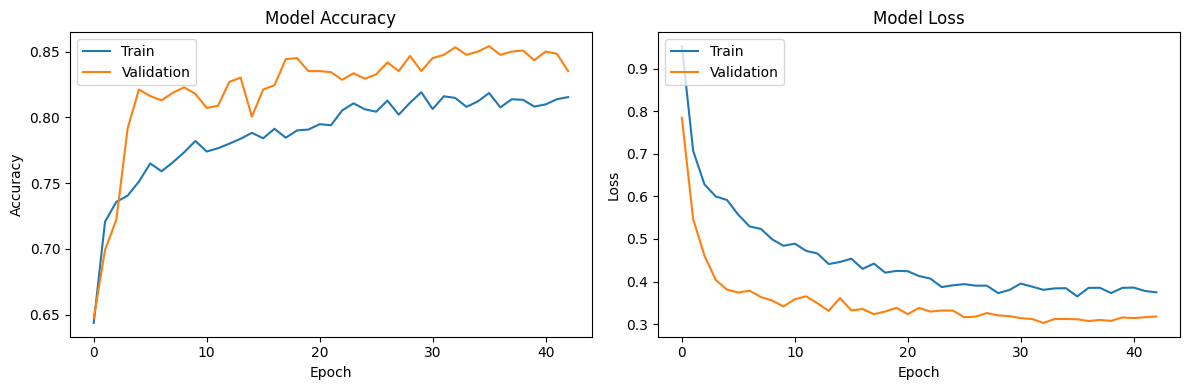

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step


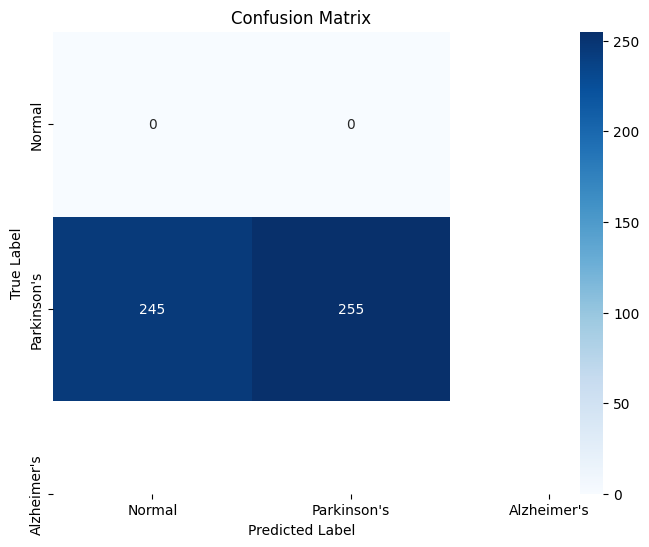


Classification Report:


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [ ]:
# Train multi-class classification model
multiclass_model, multiclass_history = train_multiclass_model()



In [ ]:

# # Identify biomarkers using the binary model
# binary_train, binary_val, binary_test = prepare_binary_dataset()
# identify_biomarkers(binary_model, binary_test)

In [ ]:



# Print summary of findings
print("\nSummary of Findings:")
print("1. Binary Classification (Parkinson's vs. Normal):")
print(f"   - Accuracy: {binary_history.history['val_accuracy'][-1]:.4f}")
print(f"   - Precision: {binary_history.history['val_precision'][-1]:.4f}")
print(f"   - Recall: {binary_history.history['val_recall'][-1]:.4f}")
print(f"   - AUC: {binary_history.history['val_auc'][-1]:.4f}")

# print("\n2. Multi-class Classification (Parkinson's vs. Normal vs. Alzheimer's):")
# print(f"   - Accuracy: {multiclass_history.history['val_accuracy'][-1]:.4f}")
# print(f"   - Precision: {multiclass_history.history['val_precision'][-1]:.4f}")
# print(f"   - Recall: {multiclass_history.history['val_recall'][-1]:.4f}")
# print(f"   - AUC: {multiclass_history.history['val_auc'][-1]:.4f}")

# print("\n3. Biomarker Identification:")
# print("   - Visualization of important regions using Grad-CAM has been performed.")
# print("   - These visualizations can help medical professionals identify potential biomarkers.")
# print("   - Further clinical validation is needed to confirm these findings.")

# print("\nConclusion:")
# print("This study demonstrates the potential of deep learning, particularly CNNs, in detecting Parkinson's disease from MRI images.")
# print("The developed models show promising performance in both binary and multi-class classification tasks.")
# print("The Grad-CAM visualization technique helps identify regions in MRI images that may contain important biomarkers for Parkinson's disease.")
# print("These findings contribute to the development of non-invasive diagnostic tools for early detection of Parkinson's disease.")


Summary of Findings:
1. Binary Classification (Parkinson's vs. Normal):
   - Accuracy: 0.9951
   - Precision: 1.0000
   - Recall: 0.9895
   - AUC: 1.0000
